[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/024_mlp_clasificacion/mlp_clasificacion.ipynb)

# El Perceptrón Multicapa - Clasificación

## El Perceptrón Multicapa

En el [post](https://sensioai.com/blog/023_mlp_backprop) anterior hemos introducido el modelo de `Perceptrón Multicapa`, o MLP, la arquitectura de red neuronal más básica basada en el [Perceptrón](https://sensioai.com/blog/012_perceptron1). Hemos visto cómo calcular la salida de un MLP de dos capas a partir de unas entradas y cómo encontrar los pesos óptimos para una tarea de regresión. En este post vamos a mejorar la implementación de nuestro MLP de dos capas para que sea capaz también de llevar a cabo tareas de clasificación.

![](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)

## Implementación

La mayoría del código que utilizaremos fue desarrollado para el `Perceptrón` y lo puedes encontrar en este [post](https://sensioai.com/blog/018_perceptron_final). Lo único que cambiaremos es la lógica del modelo, el resto de funcionalidad (funciones de pérdida, funciones de activación, etc, siguen siendo exactamente igual).

### Funciones de activación

Para la capa oculta de nuestro MLP utilizaremos una función de activación de tipo `relu`, de la cual necesitaremos su derivada.

In [1]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

En cuanto a las funciones de activación que utilizaremos a la salida del MLP, éstas son las que hemos introducido en posts anteriores:

- Lineal: usada para regresión (junto a la función de pérdida MSE).
- Sigmoid: usada para clasificación binaria (junto a la función de pérdida BCE).
- Softmax: usada para clasificación multiclase (junto a la función de pérdida CE).

In [2]:
def linear(x):
    return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

### Funciones de pérdida

Cómo acabamos de comentar en la sección anterior, estas son las funciones de pérdida que hemos visto hasta ahora para las diferentes tareas.

In [3]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Y sus derivadas

In [4]:
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1    
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

### Implementación MLP

Ahora que ya tenemos definidas las diferentes funciones de activación y de pérdida que necesitamos, vamos a implementar nuestro MLP de dos capas capaz de llevar a cabo tanto tareas de regresión como de clasificación. Del mismo modo que ya hicimos con el `Perceptrón`, definiremos una clase base que servirá para la implementación de las clases particulares para cada caso.

In [12]:
class MLP():
  def __init__(self, D_in, H, D_out, loss, grad_loss, activation):
    # pesos de la capa 1
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    # pesos de la capa 2
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)
    self.ws = []
    self.loss = loss
    self.grad_loss = grad_loss
    self.activation = activation

  def __call__(self, x):
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    y_hat = np.dot(self.h, self.w2) + self.b2 
    return self.activation(y_hat)
    
  def fit(self, X, Y, epochs = 100, lr = 0.001, batch_size=None, verbose=True, log_each=1):
    batch_size = len(X) if batch_size == None else batch_size
    batches = len(X) // batch_size
    l = []
    for e in range(1,epochs+1):     
        # Mini-Batch Gradient Descent
        _l = []
        for b in range(batches):
            x = X[b*batch_size:(b+1)*batch_size]
            y = Y[b*batch_size:(b+1)*batch_size]        
            y_pred = self(x) 
            loss = self.loss(y, y_pred)
            _l.append(loss)        
            # Backprop 
            dldy = self.grad_loss(y, y_pred) 
            grad_w2 = np.dot(self.h.T, dldy)
            grad_b2 = dldy.mean(axis=0)
            dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)      
            grad_w1 = np.dot(x.T, dldh)
            grad_b1 = dldh.mean(axis=0)
            # Update (GD)
            self.w1 = self.w1 - lr * grad_w1
            self.b1 = self.b1 - lr * grad_b1
            self.w2 = self.w2 - lr * grad_w2
            self.b2 = self.b2 - lr * grad_b2
        l.append(np.mean(_l))
        self.ws.append((
            self.w1.copy(),
            self.b1.copy(),
            self.w2.copy(),
            self.b2.copy()
        ))
        if verbose and not e % log_each:
            print(f'Epoch: {e}/{epochs}, Loss: {np.mean(l):.5f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.activation(y_hat)

In [13]:
class MLPRegression(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, mse, grad_mse, linear)
        
class MLPBinaryClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, bce, grad_bce, sigmoid)
        
class MLPClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, crossentropy, grad_crossentropy, linear)

Vamos a probar ahora nuestra implementación para diferentes ejemplos.

## Regresión

En primer lugar, vamos a replicar los resultados obtenidos en el post anterior para verificar que nuestro modelo de MLP sigue funcionando bien.

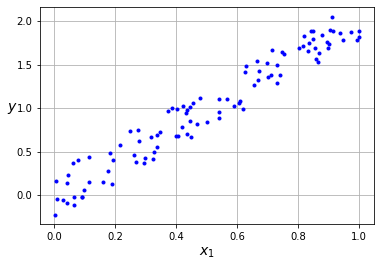

In [31]:
import numpy as np
import matplotlib.pyplot as plt

x = np.random.rand(100)
X = x.reshape(-1, 1)
y = 2*x + (np.random.rand(100)-0.5)*0.5

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [35]:
model = MLPRegression(D_in=1, H=3, D_out=1)
epochs, lr = 50, 0.01
model.fit(x.reshape(len(x),1), y, epochs, lr, log_each=10)

Epoch: 10/50, Loss: 0.11860
Epoch: 20/50, Loss: 0.07060
Epoch: 30/50, Loss: 0.05456
Epoch: 40/50, Loss: 0.04651
Epoch: 50/50, Loss: 0.04167


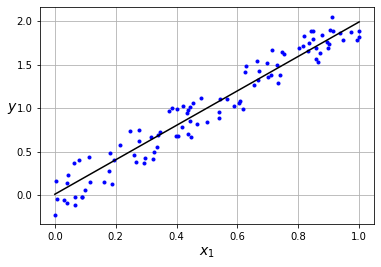

In [36]:
x_new = np.linspace(0, 1, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = model(x_new)
    
plt.plot(x, y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

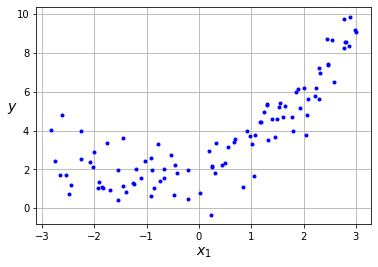

In [37]:
m = 100
x = 6 * np.random.rand(m, 1) - 3
y = 0.5 * x**2 + x + 2 + np.random.randn(m, 1)

plt.plot(x, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [58]:
model = MLPRegression(D_in=1, H=3, D_out=1)
epochs, lr = 50, 0.01
model.fit(x.reshape(len(x),1), y, epochs, lr, batch_size=10, log_each=10)

Epoch: 10/50, Loss: 2.14122
Epoch: 20/50, Loss: 1.68733
Epoch: 30/50, Loss: 1.52441
Epoch: 40/50, Loss: 1.43771
Epoch: 50/50, Loss: 1.38278


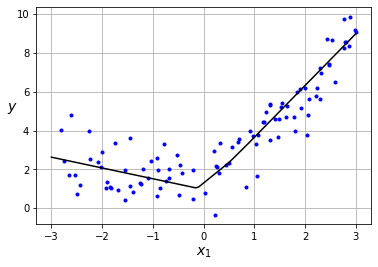

In [59]:
x_new = np.linspace(-3, 3, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = model(x_new)
    
plt.plot(x, y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

## Clasificación Binaria

Ahora vamos a aplicar nuestro MLP al problema de clasificación binaria. Para ellos vamos a utilizar el dataset Iris, que ya conocemos de los posts anteriores de clasificación con el `Perceptrón`.

In [132]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = iris.target

X.shape, y.shape

((150, 2), (150,))

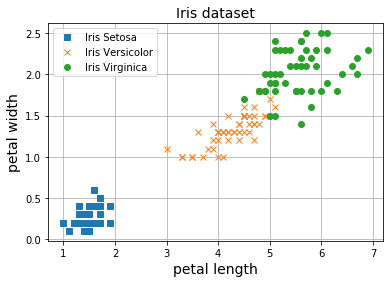

In [133]:
plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Este dataset contiene información sobre flores y el objetivo es clasificar en tres clases distintas. En esta sección vamos a intentar separar simplemente una de las clases del resto.

In [134]:
y = (iris.target == 0).astype(np.int)

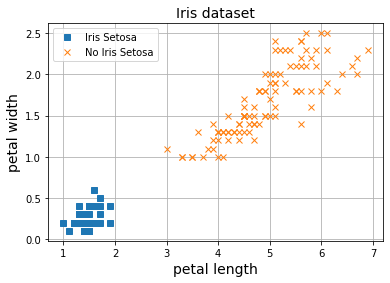

In [135]:
plt.plot(X[y==1, 0], X[y==1, 1], 's', label="Iris Setosa")
plt.plot(X[y==0, 0], X[y==0, 1], 'x', label="No Iris Setosa")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [136]:
model = MLPBinaryClassification(D_in=2, H=3, D_out=1)
epochs, lr = 50, 0.02

# normalización datos
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

model.fit(X_norm, y, epochs, lr, batch_size=10, log_each=10)

Epoch: 10/50, Loss: -0.27318
Epoch: 20/50, Loss: -0.16367
Epoch: 30/50, Loss: -0.11997
Epoch: 40/50, Loss: -0.09608
Epoch: 50/50, Loss: -0.08072


In [74]:
from matplotlib import animation, rc
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#9898ff', '#fafab0'])
rc('animation', html='html5')

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
def plot(i, axes = [0, 5, 0, 2], label="Iris Setosa"):
    ax.clear()
    w = model.ws[i]
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    x0, x1 = np.meshgrid(
            np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
            np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    X_new = np.c_[np.ones(len(X_new)), X_new] 
    y_predict = model.predict(w, X_new)
    zz = y_predict.reshape(x0.shape)
    ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
    ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
    ax.contourf(x0, x1, zz, cmap=custom_cmap)
    ax.set_xlabel("Petal length", fontsize=14)
    ax.set_ylabel("Petal width", fontsize=14)
    ax.legend(loc="lower right", fontsize=14)
    ax.axis(axes)
    return ax

anim = animation.FuncAnimation(fig, plot, frames=epochs, interval=200)
plt.close()
anim

MovieWriter stderr:
[h264_videotoolbox @ 0x7f8b6500b800] Error: cannot create compression session: -12915
[h264_videotoolbox @ 0x7f8b6500b800] Try -allow_sw 1. The hardware encoder may be busy, or not supported.
Error initializing output stream 0:0 -- Error while opening encoder for output stream #0:0 - maybe incorrect parameters such as bit_rate, rate, width or height



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x360', '-pix_fmt', 'rgba', '-r', '5.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/h2/rjnw6g5d2jn_b_5rgzp074z80000gn/T/tmp2m11gs9u/temp.m4v']' returned non-zero exit status 1.

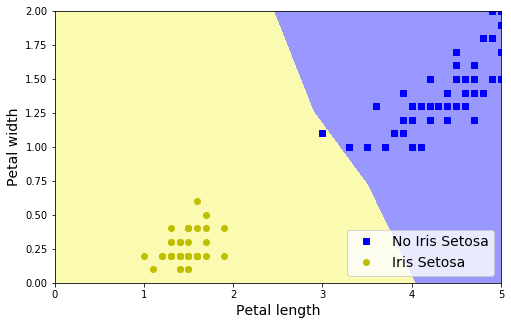

In [137]:
axes = [0, 5, 0, 2]
label="Iris Setosa"
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
ax.clear()
w = model.ws[-1]
#tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - X_mean) / X_std
y_predict = model.predict(w, X_new)
zz = y_predict.reshape(x0.shape)
ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
ax.contourf(x0, x1, zz, cmap=custom_cmap)
ax.set_xlabel("Petal length", fontsize=14)
ax.set_ylabel("Petal width", fontsize=14)
ax.legend(loc="lower right", fontsize=14)
ax.axis(axes)
plt.show()

Si recuerdas, en el caso del `Perceptrón` el modelo no era capaz de separar las flores de tipo *Iris Versicolor* del resto, ya que esta clase no es linealmente separable.

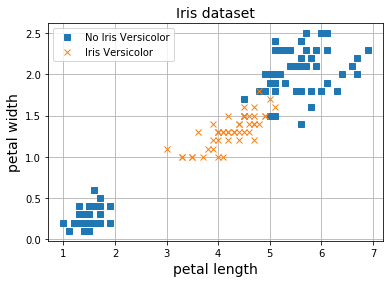

In [140]:
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 1).astype(np.int)

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="No Iris Versicolor")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

Sin embargo, nuestro nuevo modelo, el MLP, es capaz de solventar este problema.

In [141]:
model = MLPBinaryClassification(D_in=2, H=200, D_out=1)
epochs, lr = 50, 0.1
model.fit(X_norm, y, epochs, lr, batch_size=1, log_each=10)

Epoch: 10/50, Loss: 0.00708
Epoch: 20/50, Loss: 0.00143
Epoch: 30/50, Loss: -0.00162
Epoch: 40/50, Loss: -0.00361
Epoch: 50/50, Loss: -0.00499


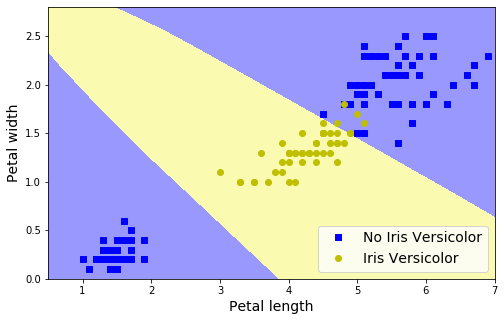

In [142]:
axes = [0.5, 7, 0, 2.8]
label="Iris Versicolor"
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
ax.clear()
w = model.ws[-1]
#tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - X_mean) / X_std
y_predict = model.predict(w, X_new)
zz = y_predict.reshape(x0.shape)
ax.plot(X[y==0, 0], X[y==0, 1], "bs", label=f"No {label}")
ax.plot(X[y==1, 0], X[y==1, 1], "yo", label=label)
ax.contourf(x0, x1, zz, cmap=custom_cmap)
ax.set_xlabel("Petal length", fontsize=14)
ax.set_ylabel("Petal width", fontsize=14)
ax.legend(loc="lower right", fontsize=14)
ax.axis(axes)
plt.show()

## Clasificación Multiclase

Por último vamos a ver cómo aplicar nuestro modelo para clasificación en multiples clases.

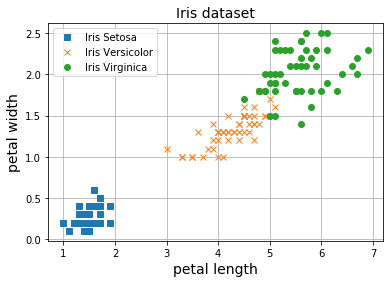

In [143]:
X = iris.data[:, (2, 3)]  # petal length, petal width
y = iris.target

X_mean, X_std = X.mean(axis=0), X.std(axis=0)
X_norm = (X - X_mean) / X_std

plt.plot(X[y==0, 0], X[y==0, 1], 's', label="Iris Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], 'x', label="Iris Versicolor")
plt.plot(X[y==2, 0], X[y==2, 1], 'o', label="Iris Virginica")
plt.grid()
plt.legend()
plt.xlabel('petal length', fontsize=14)
plt.ylabel('petal width', fontsize=14)
plt.title("Iris dataset", fontsize=14)
plt.show()

In [169]:
model = MLPClassification(D_in=2, H=200, D_out=3)
epochs, lr = 200, 0.1
model.fit(X_norm, y, epochs, lr, batch_size=10, log_each=20)

Epoch: 20/200, Loss: 0.38295
Epoch: 40/200, Loss: 0.27266
Epoch: 60/200, Loss: 0.21871
Epoch: 80/200, Loss: 0.18773
Epoch: 100/200, Loss: 0.16779
Epoch: 120/200, Loss: 0.15393
Epoch: 140/200, Loss: 0.14377
Epoch: 160/200, Loss: 0.13600
Epoch: 180/200, Loss: 0.12987
Epoch: 200/200, Loss: 0.12492


In [145]:
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
rc('animation', html='html5')       
    
def animate(i, resolution=0.02):
    ax.clear()
    tit = ax.set_title(f"Epoch {i+1}", fontsize=14)
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
    X_new = np.c_[np.ones(len(X_new)), X_new]
    w = perceptron.ws[i]
    Z = perceptron(w, X_new)
    Z = np.argmax(softmax(Z), axis=1) 
    #print(Z)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())
    ax.set_xlabel('petal length', fontsize=14)
    ax.set_ylabel('petal width', fontsize=14)
    classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=classes[cl], 
                    edgecolor='black')
    ax.legend(loc='upper left', fontsize=14)
    return [tit]

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
anim = animation.FuncAnimation(fig, animate, frames=epochs, interval=100, blit=True)
plt.close()
anim

Traceback (most recent call last):
  File "/Users/juansensio/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/Users/juansensio/miniconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 953, in _start
    self._init_draw()
  File "/Users/juansensio/miniconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1732, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/juansensio/miniconda3/lib/python3.7/site-packages/matplotlib/animation.py", line 1755, in _draw_frame
    self._drawn_artists = self._func(framedata, *self._args)
  File "<ipython-input-145-ab2b86ad8024>", line 20, in animate
    w = perceptron.ws[i]
NameError: name 'perceptron' is not defined
MovieWriter stderr:
[h264_videotoolbox @ 0x7f9c7580a600] Error: cannot create compression session: -12915
[h264_videotoolbox @ 0x7f9c7580a600] Try -allow_sw 1. The hardware encoder may be busy, or not supported.
Er

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '576x360', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/h2/rjnw6g5d2jn_b_5rgzp074z80000gn/T/tmpusr3l230/temp.m4v']' returned non-zero exit status 1.

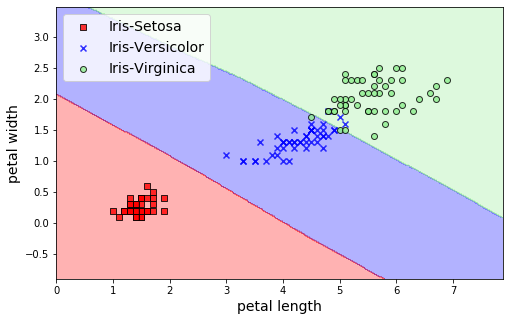

In [170]:
resolution=0.02
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, autoscale_on=False)
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
cmap = ListedColormap(colors[:len(np.unique(y))])

# plot the decision surface
x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))
X_new = (np.array([xx1.ravel(), xx2.ravel()]).T - X_mean)/X_std
w = model.ws[-1]
Z = model.predict(w, X_new)
Z = np.argmax(softmax(Z), axis=1) 
#print(Z)
Z = Z.reshape(xx1.shape)
ax.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xlabel('petal length', fontsize=14)
ax.set_ylabel('petal width', fontsize=14)
classes = ["Iris-Setosa", "Iris-Versicolor", "Iris-Virginica"]
for idx, cl in enumerate(np.unique(y)):
    ax.scatter(x=X[y == cl, 0], 
                y=X[y == cl, 1],
                alpha=0.8, 
                c=colors[idx],
                marker=markers[idx], 
                label=classes[cl], 
                edgecolor='black')
ax.legend(loc='upper left', fontsize=14)
plt.show()

## Resumen

En este post hemos visto como implementar un `Perceptrón Multicapa` en `Python` para tareas de regresión y clasificación. Como ya hicimos anteriormente para el caso del `Perceptrón` hemos validado nuestra implementación con el dataset de clasificación de flores *Iris*, tanto para clasificación binaria como multiclase. Sin embargo, nuestra implementación está muy limitada. ¿Qué pasa si queremos usar un MLP de más de dos capas?, ¿y si queremos usar una función de activación diferente a la `relu` en la capa oculta?, ¿podríamos utilizar un algoritmo de optimizaciñon diferente al `descenso por gradiente`? Para poder hacer todo esto necesitamos un `framework` más flexible, similar a lo que nos ofrecen `Pytorch` y `Tensorflow`. En el siguiente post desarrollaremos nuestro propio framework de MLP para que sea más flexible y que también nos servirá para entender cómo funcionan el resto de frameworks de `redes neuronales` por dentro.